In [1]:
import functools
import numpy as np
import sympy
import matplotlib.pyplot as plt
import keras
import keras.backend as K
sympy.init_printing()

Using TensorFlow backend.


In [2]:
a,b = sympy.symbols('a,b')
iFa = sympy.exp(-((a**2+b**2)**0.5/5)**4)
iFb = -sympy.exp(-((a**2+b**2)**0.5/5)**2)
Fa = iFa.diff(a)
Fb = iFb.diff(b)
Fab = iFa.diff(b)
Fba = iFb.diff(a)
dFa = Fa.diff(a)
dFb = Fb.diff(b)
lambda_iFa = sympy.lambdify((a,b), iFa)
lambda_iFb = sympy.lambdify((a,b), iFb)
lambda_Fa = sympy.lambdify((a,b), Fa)
lambda_Fb = sympy.lambdify((a,b), Fb)
lambda_Fab = sympy.lambdify((a,b), Fab)
lambda_Fba = sympy.lambdify((a,b), Fba)
lambda_dFa = sympy.lambdify((a,b), dFa)
lambda_dFb = sympy.lambdify((a,b), dFb)
display((iFa, Fa, dFa))
display((iFb, Fb, dFb))
display((Fab, Fba))

In [3]:
def ks(l, *args): # ks stand for keep shape
    r = l(*args)
    if type(r) == int or type(r) == float or not r.shape:
        r = np.repeat(r, args[0].shape)
    return r
lambda_F = lambda v: np.stack([ks(lambda_Fa,v[:,0],v[:,1]), ks(lambda_Fb,v[:,0],v[:,1])], axis=-1)
lambda_jF = lambda v: np.stack([ks(lambda_Fab,v[:,0],v[:,1]), ks(lambda_Fba,v[:,0],v[:,1])], axis=-1)
lambda_iF = lambda v: np.stack([ks(lambda_iFa,v[:,0],v[:,1]), ks(lambda_iFb,v[:,0],v[:,1])], axis=-1)
lambda_dF = lambda v: np.stack([ks(lambda_dFa,v[:,0],v[:,1]), ks(lambda_dFb,v[:,0],v[:,1])], axis=-1)
xtrain = (np.random.random((100000,2)) - 0.5) * 20
xtest = (np.random.random((10,2)) - 0.5) * 20
ytrain, ytest = lambda_F(xtrain), lambda_F(xtest)

In [4]:
def build_nn_pair():
    X = X_input = keras.layers.Input((2,))
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dense(128, activation='tanh')(X)
    for _ in range(3):
        X_skip = X
        X = keras.layers.Dense(128, activation='relu')(X)
        X = keras.layers.Dense(128)(X)
        X = keras.layers.Add()([X, X_skip])
        X = keras.layers.Activation('tanh')(X)
    X = keras.layers.Dense(2)(X)
    M_Integral = keras.Model(X_input, X)
    M_Integral.compile('nadam', 'mse', ['mae'])
    X = M_Integral(X_input)
    def compute_jacobian(x):
        return K.reshape(K.stack([
            K.gradients(x[1][:,ix], x[0])[0]
            for ix in range(2)
        ], axis=1), (-1,2,2))
    def compute_grad(x):
        j = compute_jacobian(x)
        return K.reshape(K.stack([
            j[:,ix,ix]
            for ix in range(2)
        ], axis=1), (-1,2))
    X = keras.layers.Lambda(
        lambda x: compute_grad(x) + K.sum(x[1])*0,
        output_shape=(2,))([X_input, X])
    M_DIntegral = keras.Model(X_input, X)
    M_DIntegral.compile('nadam', 'mse', ['mae'])
    X = M_Integral(X_input)
    def compute_other_jacobian_elements(x):
        j = compute_jacobian(x)
        return K.reshape(K.stack([
            j[:,ix,1-ix]
            for ix in range(2)
        ], axis=1), (-1,2))
    X = keras.layers.Lambda(
        lambda x: compute_other_jacobian_elements(x) + K.sum(x[1])*0,
        output_shape=(2,))([X_input, X])
    M_JIntegral = keras.Model(X_input, X)
    M_JIntegral.compile('nadam', 'mse', ['mae'])
    return M_Integral, M_DIntegral, M_JIntegral

In [5]:
M_Integral, M_DIntegral, M_JIntegral = build_nn_pair()
M_IDerivative, M_Derivative, _ = build_nn_pair()
X = X_input = keras.layers.Input((2,))
X_DI = M_DIntegral(X_input)
X_ID = M_IDerivative(X_input)
X_add = keras.layers.Lambda(lambda x: sum(x) / 2)([X_DI, X_ID])
X_sub = keras.layers.Lambda(lambda x: (x[1] - x[0]) / 2)([X_DI, X_ID])
X_sub = keras.layers.ActivityRegularization(l2=0.01)(X_sub)
X = keras.layers.Add()([X_add, X_sub])
M = keras.Model(X_input, X)
M.compile('nadam', 'mse', ['mae'])
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 2)            99722       input_3[0][0]                    
__________________________________________________________________________________________________
model_4 (Model)                 (None, 2)            99722       input_3[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 2)            0           model_2[1][0]                    
                                                                 model_4[3][0]                    
__________

In [6]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=256, epochs=20, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
    keras.callbacks.EarlyStopping(patience=10),
])

Train on 100000 samples, validate on 10 samples
Epoch 1/20
100000/100000 [==============================] - 8s 82us/step - loss: 0.0156 - mean_absolute_error: 0.0501 - val_loss: 0.0018 - val_mean_absolute_error: 0.0296
Epoch 2/20
100000/100000 [==============================] - 6s 64us/step - loss: 0.0021 - mean_absolute_error: 0.0258 - val_loss: 8.3889e-04 - val_mean_absolute_error: 0.0181
Epoch 3/20
100000/100000 [==============================] - 6s 62us/step - loss: 0.0017 - mean_absolute_error: 0.0234 - val_loss: 6.3600e-04 - val_mean_absolute_error: 0.0186
Epoch 4/20
100000/100000 [==============================] - 6s 61us/step - loss: 0.0014 - mean_absolute_error: 0.0222 - val_loss: 4.0631e-04 - val_mean_absolute_error: 0.0136
Epoch 5/20
100000/100000 [==============================] - 6s 61us/step - loss: 0.0013 - mean_absolute_error: 0.0217 - val_loss: 0.0015 - val_mean_absolute_error: 0.0246
Epoch 6/20
100000/100000 [==============================] - 6s 62us/step - loss: 0.00

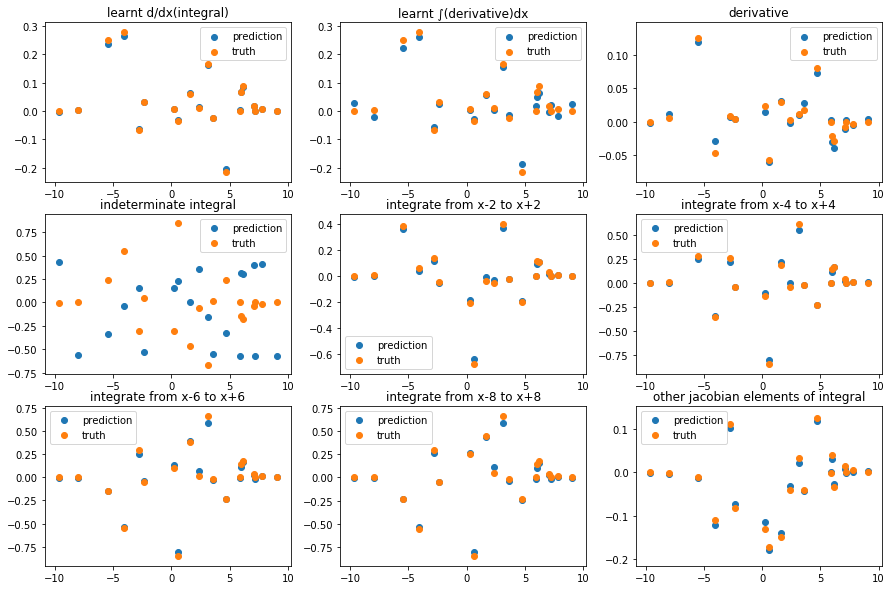

In [7]:
plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title('learnt d/dx(integral)')
plt.scatter(xtest, M_DIntegral.predict(xtest), label='prediction')
plt.scatter(xtest, ytest, label='truth')
plt.legend()
plt.subplot(3,3,2)
plt.title('learnt ∫(derivative)dx')
plt.scatter(xtest, M_IDerivative.predict(xtest), label='prediction')
plt.scatter(xtest, ytest, label='truth')
plt.legend()
plt.subplot(3,3,3)
plt.title('derivative')
plt.scatter(xtest, M_Derivative.predict(xtest), label='prediction')
plt.scatter(xtest, lambda_dF(xtest), label='truth')
plt.legend()
plt.subplot(3,3,4)
plt.title('indeterminate integral')
plt.scatter(xtest, M_Integral.predict(xtest), label='prediction')
plt.scatter(xtest, lambda_iF(xtest), label='truth')
plt.legend()
for i in range(4):
    D = (i+1)*2
    plt.subplot(3,3,i+5)
    plt.title(f'integrate from x-{D} to x+{D}')
    plt.scatter(xtest, M_Integral.predict(xtest + D) - M_Integral.predict(xtest), label='prediction')
    plt.scatter(xtest, lambda_iF(xtest + D) - lambda_iF(xtest), label='truth')
    plt.legend()
plt.subplot(3,3,9)
plt.title('other jacobian elements of integral')
plt.scatter(xtest, M_JIntegral.predict(xtest), label='prediction')
plt.scatter(xtest, lambda_jF(xtest), label='truth')
plt.legend()
plt.show()